# Image classification with CNN algorithm

# Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


['train', 'test1']


['train', 'test1']


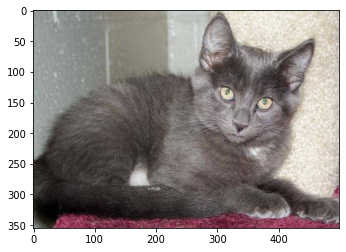

In [29]:
print(os.listdir("input"))

# Initials
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3



filenames = os.listdir("input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

#df.head()

# See sample image
sample = random.choice(filenames)
image = load_img("input/train/"+sample)
plt.imshow(image)

# The model

In [5]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit_generator(train_generator, epochs=1,validation_data=validation_generator
    ,validation_steps=total_validate//batch_size,steps_per_epoch=total_train//batch_size,callbacks=callbacks)

#model.summary()

304/304 [==============================] - 96s 317ms/step - loss: 1.0282 - accuracy: 0.5723 - val_loss: 1.0017 - val_accuracy: 0.5421 - lr: 0.0010


# Save the model

In [26]:
model.save_weights("model.h5")

import joblib

# Save the model
joblib.dump(model, "DogCatCassificationAnvil.joblib")


TypeError: can't pickle _thread.RLock objects

# Load the model

In [27]:
model.load_weights("model.h5")

# Make prediction

cat 0.9593815803527832


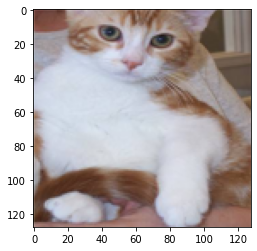

In [16]:
import PIL.Image

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

test_img = load_img("input/train/cat.9.jpg")


test_img = test_img.resize((128,128) , resample=PIL.Image.BICUBIC)

test_arr = img_to_array(test_img)
test_arr = np.expand_dims(test_arr,axis = 0)
test_arr /= 255.0

plt.imshow(test_img)
score = model.predict(test_arr)

print('dog' if score[0][0] < 0.5 else 'cat', score[0][1] if score[0][0] < 0.5 else  float(score[0][0]))

# Anvil server

In [13]:

import anvil.server

anvil.server.connect("JWT4TFQ6D5PCLZLACVS2JMUG-HDWQFUPSO2YIXR7D")


Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK


In [14]:
import anvil.media

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = load_img(filename)
       
    img = img.resize((128, 128), resample=PIL.Image.BICUBIC)
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr /= 255
    score1 = model.predict(arr)
    #score = score1[0][0]
    return('dog' if score1[0][0] < 0.5 else 'cat', score1[0][1] if score1[0][0] < 0.5 else  score1[0][0])